# Analyze A/B Test Results




## Shakhawat Hassan



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.
For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

#### Part I - Probability

To get started, let's import our libraries.

In [152]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [153]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [154]:
total_users = df.shape[0]
total_users

294478

c. The number of unique users in the dataset.

In [155]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [156]:
converted = df.query('converted == "1"').user_id.nunique() / total_users
converted

# Only 11.94 % users converted!

0.1194418598333322

e. The number of times the `new_page` and `treatment` don't match.

In [157]:
df.query('(group != "treatment" and landing_page == "new_page") or (group == "treatment" and landing_page !="new_page")')['user_id'].count()

3893

f. Do any of the rows have missing values?

In [158]:
null_data = df[df.isnull().any(axis =1)].count()
null_data

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [159]:
df2 = df.drop(df.query('(group != "treatment" and landing_page == "new_page") or (group == "treatment" and landing_page !="new_page") or (group != "control" and landing_page == "old_page") or (group == "control" and landing_page !="old_page")')['user_id'].index)

In [160]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [161]:
#number of unique id's
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [162]:
df2[df2.duplicated(['user_id'], keep =False)]['user_id']
#duplicated rows in df2

1899    773192
2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [163]:
df2[df2['user_id'] ==773192]

#landing_page for the non-unique id is new_page and group is treatment

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [164]:
#drop duplicate and keep the last
df2.drop(df2.query('index == 1899').index, inplace =True)
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [165]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [166]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [167]:
df2.query('group == "control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [168]:
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [169]:
#total user
total_user = df2.user_id.count()

In [170]:
#calculate who received the new page
df2.query('group == "treatment"').user_id.count()/total_user



0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

The total percentage of treatment group of people who received the new page is about 50%. On the same hand, there is only total of 11.96% of people who converted and treatment group converted about 11.88%. According to the calculation, for those who recieved a new page they're more likely convert.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.


$$H_0: p_{old} \geq p_{new}  $$

$$H_1: p_{old} < p_{new}  $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [171]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [172]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [173]:
n_new = len (df2.query('group == "treatment"'))
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [174]:
n_old = len (df2.query('group == "control"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [175]:
new_page_converted = np.random.choice([0,1], n_new, p=(p_new, 1-p_new)).mean()

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [176]:
old_page_converted = np.random.choice([0,1], n_old, p=[p_old, 1-p_old]).mean()

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [177]:
new_page_converted - old_page_converted

-0.0007893420910825011

In [178]:
# it's so close to zero

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [179]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([0,1], n_new, p=(p_new, 1-p_new)).mean()
    old_page_converted = np.random.choice([0,1], n_old, p=[p_old, 1-p_old]).mean()
    p_diffs.append(new_page_converted - old_page_converted)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Text(0.5, 1.0, 'Simulated p_diffs ')

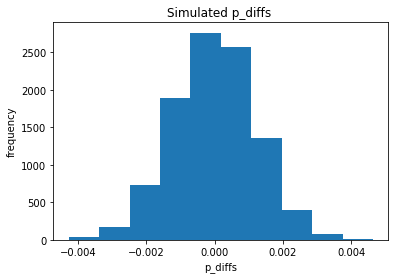

In [180]:
plt.hist(p_diffs)
plt.xlabel("p_diffs")
plt.ylabel("frequency")
plt.title("Simulated p_diffs ")

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [181]:
actual_diffs = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()
actual_diffs

-0.0015782389853555567

In [182]:
(p_diffs > actual_diffs).mean()

0.9032

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**ANSWER: First, I created sampling distribution for finding the difference in conversation rates, and then I computed the p-value. As we know that if the p-value is less than 0.05 (5%) then we would have statistical significance. If it is more than 0.05, then there would be no significant. In this case, the p-value is 0.91 which suggests that we have failed to reject the null hypothesis. As a result, the old page performs well as a new page.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [183]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"').converted.sum()
convert_new = df2.query('group == "treatment"').converted.sum()
n_old = len (df2.query('group == "control"'))
n_new = len (df2.query('group == "treatment"'))

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [184]:
z_scr, pval = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller')
print((z_scr))
print((pval))

1.3109241984234394
0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages? Do they agree with the findings in parts j. and k.?

In [185]:
#finding the accuracy
from scipy.stats import norm
print(norm.cdf(z_scr))
print(norm.ppf(1-(0.05/2)))

0.9050583127590245
1.959963984540054


**ANSWER: As z-score suggests the previous z-score is less than 1.95 which tells us we have failed to reject the null hypothesis. And yes they do agree with the findings in j. and k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Rgression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [186]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [187]:
ab_page = pd.get_dummies(df2['group']) ['treatment']
df_new = df2.join(ab_page)
df_new.head()

,user_id,timestamp,group,landing_page,converted,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0


In [188]:
df_new['intercept'] = 1
df_new.rename({'treatment': 'ab_page'}, axis =1, inplace=True)
df_new.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [189]:
#statsmodels
import statsmodels.api as sm

log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [190]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 15 May 2020   Pseudo R-squ.:               8.077e-06
Time:                        19:33:23   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [191]:
np.exp(results.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**ANSWER:  The p-value for the ab_page is 0.190. And they're different because I used a z-test in part 2 to get p-value and here I use a logistic regression model to get the p-value. In part 2, I have 0.90 for the p-value. If we compare these two p-values we see that the logistic model gives us a lower p-value than the z-test. Even though they have a difference in p-values, they're still more than 0.05 (p-value for statistical significance test), which means we reject the null hypothesis**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**ANSWER: It is a good idea to consider other factors such as which country has a better conversions rate higher than the other countries, and users are new or returning users, and etc. Coefficients and p-value might be a little bit off**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [192]:
import pandas as pd
df_country = pd.read_csv('countries.csv')
df_country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [193]:
df_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  290584 non-null  int64 
 1   country  290584 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


In [194]:
df_row = pd.merge(df_country, df_new, on = 'user_id', how = 'inner')
df_row.head() #merged

,user_id,country,timestamp,group,landing_page,converted,ab_page,intercept
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [195]:
df_row.rename(columns={'treatment': 'ab_page'}, inplace =True)

In [196]:
df_row[['CA', 'US']]= pd.get_dummies(df_row['country']) [['CA', 'US']]
df_row.head()

,user_id,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,US
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0


In [197]:
log_mod = sm.Logit(df_row['converted'], df_row[['intercept','CA', 'US']])
country_results = log_mod.fit()
country_results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 15 May 2020   Pseudo R-squ.:               1.521e-05
Time:                        19:33:25   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
CA            -0.0507      0.028     -1.786      0.074      -0.106       0.005
US            -0.0099      0.013     -0.746      0.456      -0.036       0.016
==============================================================================
"""

In [198]:
np.exp(country_results.params)

intercept    0.137132
CA           0.950546
US           0.990133
dtype: float64

**Interpretation: As the country columns added, the p-value is slightly more than 0.05 percent, and the US's p-value is way more than 5 percent which means we reject the null hypothesis. For exp, we see that the US is close to 1, which means the US is getting more conversation rates than other countries’ columns.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [199]:

log_mod = sm.Logit(df_row['converted'], df_row[['intercept', 'ab_page','CA', 'US']])
ab_results = log_mod.fit()
ab_results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 15 May 2020   Pseudo R-squ.:               2.323e-05
Time:                        19:33:27   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
==============================================================================
"""

In [200]:
np.exp(ab_results.params)

intercept    0.138154
ab_page      0.985168
CA           0.950621
US           0.990165
dtype: float64

**Interpretation: As the country columns added, the p-value is slightly more than 0.05 percent, and the US's p-value is way more than 5 percent which means we reject the null hypothesis. For exp, we see that the US is close to 1, which means the US is getting more conversation rates than other countries’ columns. And the ab_page is very close to 1 as well.**  

## Summary

#### Sample Distribution:
From sampling distribution,  the difference in conversation rates, and then I computed the p-value. As we know that if the p-value is less than 0.05 (5%) then we would have statistical significance. If it is more than 0.05, then there would be no significant. In this case, the p-value is 0.91 which suggests that we have failed to reject the null hypothesis.

#### Z-Test:
As z-score suggests the previous z-score is less than 1.95 which tells us we have failed to reject the null hypothesis

#### Logistic Regression:
The p-value for the ab_page is 0.190. And they're different because I used a z-test in part 2 to get p-value and here I use a logistic regression model to get the p-value. In part 2, I have 0.90 for the p-value. If we compare these two p-values we see that the logistic model gives us a lower p-value than the z-test. Even though they have a difference in p-values, they're still more than 0.05 (p-value for statistical significance test), which means we have failed to reject the null hypothesis. 


## Conclusion
After performing all these tests, we have failed to reject the null hypothesis. I can see that the old page performs well as the new page. But there is a very slight change on the new page in the conversation rate. Other than that, the A/B test suggests the company should keep the old page. There is no need to update the web page. 


## Limitations
We only judged how the page performs based on the country and the user’s conversation rate. There are other factors to consider such as return on investment (ROI). Moreover, it also great to know the demographic, gender, age, and etc. They’re also played a huge role when deciding how web-pages are performing.


In [201]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])    #should be 0

0